Model 1: ResNet50

In [54]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim

Dataset Class

In [55]:
class RockPaperScissorsDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = {'rock': 0, 'paper': 1, 'scissors': 2}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[row['class'].lower()]
        if self.transform:
            image = self.transform(image)
        return image, label

Define Transforms

In [56]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),   # Random horizontal flip augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [57]:
train_dataset = RockPaperScissorsDataset(train_df, train_img_dir, transform=train_transform)
val_dataset = RockPaperScissorsDataset(val_df, train_img_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

Load pretrained ResNet50

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # 3 classes: rock, paper, scissors

model = model.to(device)

/home/cconcha/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loss Function and Optimizer

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only train final layer

Training and Graph

Epoch [1/20] Loss: 1.1534 Validation Accuracy: 0.2833
Epoch [2/20] Loss: 1.0344 Validation Accuracy: 0.4000
Epoch [3/20] Loss: 0.9638 Validation Accuracy: 0.4167
Epoch [4/20] Loss: 0.9137 Validation Accuracy: 0.4167
Epoch [5/20] Loss: 0.9151 Validation Accuracy: 0.4000
Epoch [6/20] Loss: 0.8276 Validation Accuracy: 0.4333
Epoch [7/20] Loss: 0.8353 Validation Accuracy: 0.4667
Epoch [8/20] Loss: 0.8113 Validation Accuracy: 0.4333
Epoch [9/20] Loss: 0.7840 Validation Accuracy: 0.4667
Epoch [10/20] Loss: 0.7288 Validation Accuracy: 0.4500
Epoch [11/20] Loss: 0.7465 Validation Accuracy: 0.4167
Epoch [12/20] Loss: 0.7155 Validation Accuracy: 0.4833
Epoch [13/20] Loss: 0.7086 Validation Accuracy: 0.4167
Epoch [14/20] Loss: 0.7065 Validation Accuracy: 0.4167
Epoch [15/20] Loss: 0.6789 Validation Accuracy: 0.4167
Epoch [16/20] Loss: 0.6927 Validation Accuracy: 0.4500
Epoch [17/20] Loss: 0.6867 Validation Accuracy: 0.4500
Epoch [18/20] Loss: 0.6552 Validation Accuracy: 0.4667
Epoch [19/20] Loss:

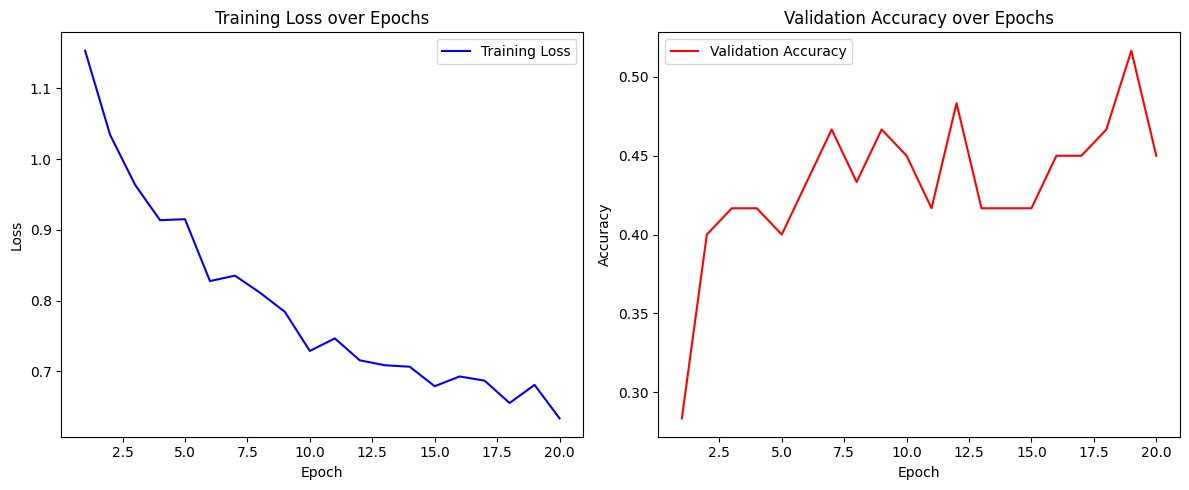

In [60]:
# --- 6. Training and validation loop ---

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation phase
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total

    train_losses.append(epoch_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Validation Accuracy: {val_acc:.4f}")

print("Training complete.")

# After training, plot learning curves
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
